Compiling model...
Building feed-forward neural network...
'build' took 0.044326 s



c:\Users\yesda\anaconda3\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.305930 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [2.71e-02, 7.41e-01, 0.00e+00, 1.00e+00]    [2.01e-02, 7.62e-01, 0.00e+00, 1.00e+00]    [1.25e+00]    
1000      [9.08e-03, 8.26e-03, 3.09e-09, 3.66e-04]    [1.04e-02, 8.05e-03, 3.09e-09, 3.66e-04]    [8.13e-01]    
2000      [5.88e-03, 4.53e-03, 6.67e-07, 1.40e-04]    [6.18e-03, 4.71e-03, 6.67e-07, 1.40e-04]    [6.38e-01]    
3000      [1.90e-03, 2.24e-03, 6.92e-07, 3.69e-05]    [2.01e-03, 2.14e-03, 6.92e-07, 3.69e-05]    [3.59e-01]    
4000      [4.09e-04, 5.88e-04, 1.83e-07, 5.49e-06]    [4.67e-04, 4.14e-04, 1.83e-07, 5.49e-06]    [1.43e-01]    
5000      [1.40e-04, 1.41e-04, 1.79e-07, 6.13e-07]    [1.35e-04, 9.31e-05, 1.79e-07, 6.13e-07]    [5.61e-02]    
6000      [5.58e-05, 4.69e-05, 4.47e-08, 1.28e-07]    [4.75e-05, 3.59e-05, 4.47e-08, 1.28e-07]    [2.41e-02]    
7000      [1.93e-05, 1.49e-05, 2.66e-08, 1.97e-08]

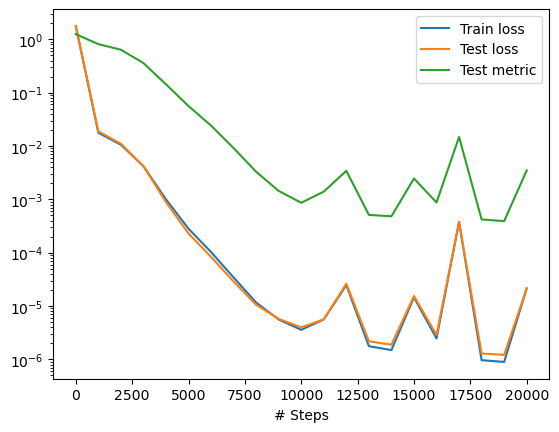

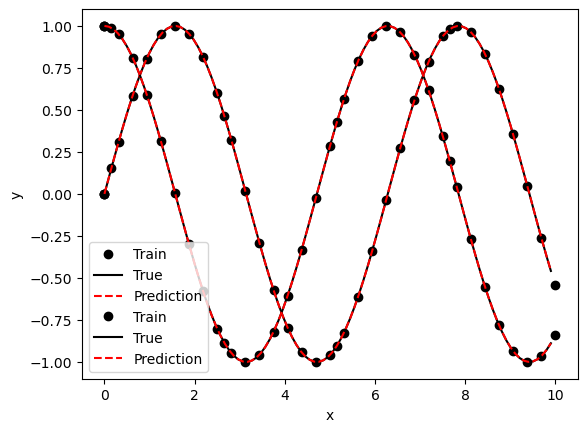

In [2]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""

import os
os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'
import matplotlib.pyplot as plt
import deepxde as dde
import numpy as np
import os

def ode_system(x, y):
    """ODE system.
    dy1/dx = y2
    dy2/dx = -y1
    """
    # Most backends
    y1, y2 = y[:, 0:1], y[:, 1:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    # Backend jax
    # y_val, y_fn = y
    # y1, y2 = y_val[:, 0:1], y_val[:, 1:]
    # dy1_x, _ = dde.grad.jacobian(y, x, i=0)
    # dy2_x, _ = dde.grad.jacobian(y, x, i=1)
    return [dy1_x - y2, dy2_x + y1]


def boundary(_, on_initial):
    return on_initial


def func(x):
    """
    y1 = sin(x)
    y2 = cos(x)
    """
    return np.hstack((np.sin(x), np.cos(x)))


geom = dde.geometry.TimeDomain(0, 10)
ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)
data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [13]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import numpy as np
# Backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
import matplotlib.pyplot as plt
# Backend pytorch
# import torch
# Backend jax
# import jax.numpy as jnp
# Backend paddle
# import paddle


def pde(x, y):
    # Most backends
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    # Backend jax
    # dy_t, _ = dde.grad.jacobian(y, x, i=0, j=1)
    # dy_xx, _ = dde.grad.hessian(y, x, i=0, j=0)
    # Backend tensorflow.compat.v1 or tensorflow
    return (
        dy_t
        - dy_xx
        + tf.exp(-x[:, 1:])
        * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
    )
    # Backend pytorch
    # return (
    #     dy_t
    #     - dy_xx
    #     + torch.exp(-x[:, 1:])
    #     * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    # )
    # Backend jax
    # return (
    #     dy_t
    #     - dy_xx
    #     + jnp.exp(-x[:, 1:])
    #     * (jnp.sin(np.pi * x[..., 0:1]) - np.pi ** 2 * jnp.sin(np.pi * x[..., 0:1]))
    # )
    # Backend paddle
    # return (
    #     dy_t
    #     - dy_xx
    #     + paddle.exp(-x[:, 1:])
    #     * (paddle.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * paddle.sin(np.pi * x[:, 0:1]))
    # )


def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

data = dde.data.TimePDE(geomtime, pde, [], num_domain=40, solution=func, num_test=10000)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
net.apply_output_transform(
    # Backend tensorflow.compat.v1 or tensorflow
    lambda x, y: x[:, 1:2] * (1 - x[:, 0:1] ** 2) * y + tf.sin(np.pi * x[:, 0:1])
    # Backend pytorch
    # lambda x, y: x[:, 1:2] * (1 - x[:, 0:1] ** 2) * y + torch.sin(np.pi * x[:, 0:1])
    # Backend jax
    # lambda x, y: x[..., 1:2] * (1 - x[..., 0:1] ** 2) * y + jnp.sin(np.pi * x[..., 0:1])
    # Backend paddle
    # lambda x, y: x[:, 1:2] * (1 - x[:, 0:1] ** 2) * y + paddle.sin(np.pi * x[:, 0:1])
)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)


Compiling model...
Building feed-forward neural network...
'build' took 0.057118 s



c:\Users\yesda\anaconda3\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.686931 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.35e+01]    [1.40e+01]    [7.26e-01]    
1000      [2.62e-03]    [4.71e-03]    [5.44e-03]    
2000      [2.96e-04]    [8.55e-04]    [1.93e-03]    
3000      [9.01e-05]    [4.75e-04]    [9.02e-04]    
4000      [4.10e-05]    [2.70e-04]    [7.55e-04]    
5000      [1.29e-04]    [2.67e-04]    [1.90e-03]    
6000      [1.67e-05]    [1.39e-04]    [3.97e-04]    
7000      [2.57e-05]    [1.42e-04]    [1.56e-03]    
8000      [1.06e-05]    [1.11e-04]    [3.13e-04]    
9000      [1.77e-05]    [1.09e-04]    [1.25e-03]    
10000     [7.79e-06]    [9.81e-05]    [2.75e-04]    

Best model at step 10000:
  train loss: 7.79e-06
  test loss: 9.81e-05
  test metric: [2.75e-04]

'train' took 7.236990 s



In [12]:
# Define points where you want to evaluate the solution
points = np.array([[0.5, 0.5], [-0.5, 0.5]])  # Example points (x, t)

# Use the trained model to predict the solution at these points
y_pred = model.predict(points)
print("Predicted solution at points:", y_pred)


Predicted solution at points: [[ 0.6063987 ]
 [-0.60620975]]


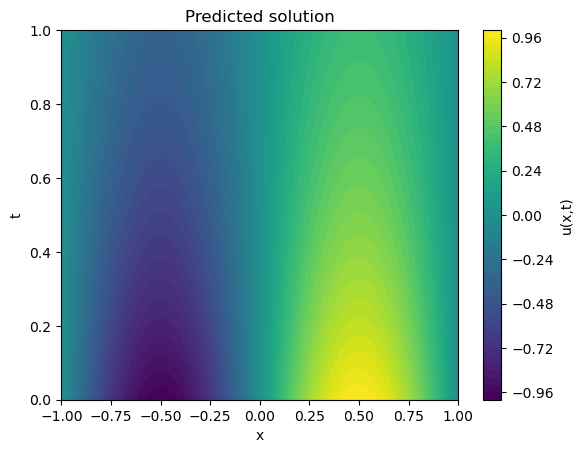

In [14]:
import matplotlib.pyplot as plt

# Create a grid of points to evaluate the solution
x = np.linspace(-1, 1, 100)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)
points = np.vstack([X.ravel(), T.ravel()]).T

# Predict the solution at these grid points
y_pred = model.predict(points).reshape(X.shape)

# Plot the solution
plt.contourf(X, T, y_pred, levels=50, cmap='viridis')
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted solution')
plt.show()


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...

'build' took 0.206246 s



c:\Users\yesda\anaconda3\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(



'compile' took 0.398862 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.60e-01]    [2.23e-01]    [1.03e+00]    
1000      [1.36e-04]    [1.53e-04]    [2.70e-02]    
2000      [4.56e-05]    [8.23e-05]    [1.99e-02]    
3000      [2.54e-05]    [5.84e-05]    [1.67e-02]    
4000      [1.99e-05]    [5.24e-05]    [1.58e-02]    
5000      [2.12e-05]    [5.05e-05]    [1.55e-02]    
6000      [1.27e-05]    [4.73e-05]    [1.51e-02]    
7000      [9.03e-06]    [4.20e-05]    [1.42e-02]    
8000      [8.25e-06]    [4.12e-05]    [1.40e-02]    
9000      [4.52e-05]    [6.94e-05]    [1.82e-02]    
10000     [2.08e-05]    [4.48e-05]    [1.47e-02]    

Best model at step 8000:
  train loss: 8.25e-06
  test loss: 4.12e-05
  test metric: [1.40e-02]

'train' took 3.059567 s

Saving loss history to c:\Users\yesda\OneDrive - Aalto University\Aalto Work\2023Hydrogen\Code\PINN_testing\loss.dat ...
Saving training data to c:\Users\yesda\OneDrive - Aalto University\Aalto 

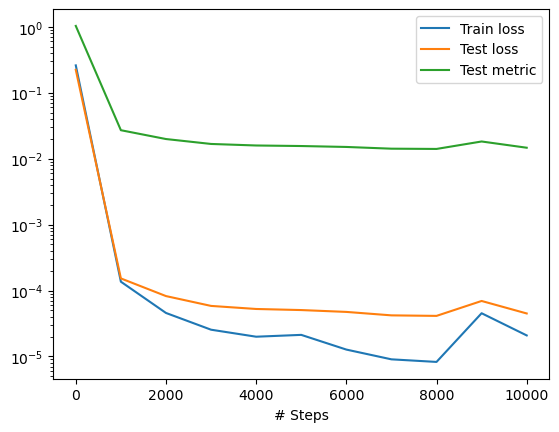

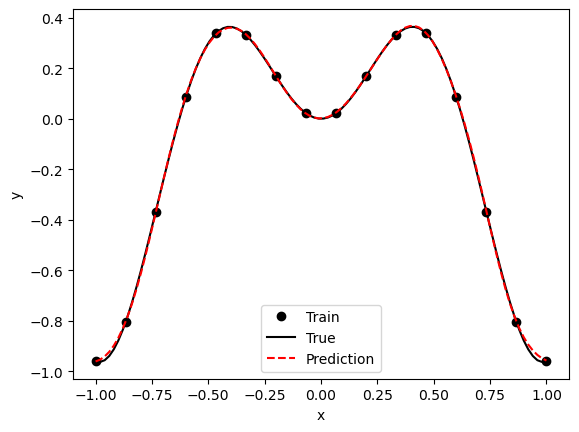

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import numpy as np


def func(x):
    """
    x: array_like, N x D_in
    y: array_like, N x D_out
    """
    return x * np.sin(5 * x)


geom = dde.geometry.Interval(-1, 1)
num_train = 16
num_test = 100
data = dde.data.Function(geom, func, num_train, num_test)

activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN([1] + [20] * 3 + [1], activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)